In [104]:
import glob
import os
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import texthero as hero
from texthero import preprocessing
sb.set()

In [105]:
steamData = pd.read_csv('steam_data/steam.csv')
steamSupportInfo = pd.read_csv('steam_data/steam_support_info.csv')
steamChart = pd.read_csv('steam_data/steamCharts.csv')
steamSpyTagData = pd.read_csv('steam_data/steamspy_tag_data.csv')
steamGames = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "steam_data/steam_games/steam_games*.csv"))))
steamMediaData = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "steam_data/steam_media_data/steam_media_data*.csv"))))
steamRequirements = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "steam_data/steam_requirements/steam_requirements*.csv"))))
steamDescription = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "steam_data/steam_description/steam_description*.csv"))))

#game reviews
steam_HalfOfTheGameReviews = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "steam_data/steam_reviews/steam_review_*.csv"))))
files = glob.glob("steam_data/steam_reviews" + '**/**' + "/*.csv")
steamReviews_fromFolder = pd.concat([pd.read_csv(f) for f in files ])
steamReviewsDF = [steam_HalfOfTheGameReviews, steamReviews_fromFolder]
steamCombinedReviews = pd.concat(steamReviewsDF)

C:\Education\Study\EE0005\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Education\Study\EE0005\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (1,23) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Education\Study\EE0005\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3437: DtypeWarning: Columns (3,4,7,12,13,14,23) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Education\Study\EE0005\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3357: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):
C:\Ed

In [106]:
#rename for easier identification
steamGames = steamGames.rename(columns={"name": "title"})

#create a custom cleaning pipeline
custom_pipeline = [preprocessing.fillna
                   , preprocessing.lowercase
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_whitespace]

steamCombinedReviews['title'] = hero.clean(steamCombinedReviews['title'], pipeline = custom_pipeline)
steamGames['title'] = hero.clean(steamGames['title'], pipeline = custom_pipeline)

In [107]:
steamGames_price = steamGames[['title', 'original_price']]
steamCombinedReviews_Title = steamCombinedReviews[['title']]
matchTitle1 = steamGames_price.title.isin(steamCombinedReviews_Title.title)
steamMatchTitle1 = steamGames_price[matchTitle1]

steamUniqueTitle1 = steamMatchTitle1.drop_duplicates(['title'])
steamUniqueTitle1 = steamUniqueTitle1.reset_index(drop=True)

steamUniqueTitle1
nan_value = float("NaN")
steamUniqueTitle1.replace("", nan_value, inplace=True)
steamUniqueTitle1.dropna(subset = ["title"], inplace=True)
steamUniqueTitle1

,title,original_price
0,playerunknown s battlegrounds,$29.99
1,battletech,$39.99
2,dayz,$44.99
3,human fall flat,$14.99
4,they are billions,$29.99
...,...,...
133,atlas,$29.99
134,metro exodus,$24.99
135,transport fever 2,$38.99
136,halo the master chief collection,$49.99


In [108]:
steam_reviewsbytitle = pd.DataFrame(steamCombinedReviews.groupby('title').count())
steam_reviewsbytitle.reset_index(level=0, inplace=True)

#extracting only title and number of reviews from dataset and cleaning anomaly
steam_reviewsbytitleonly = steam_reviewsbytitle[['title','review']]
reviews_bytitle=steam_reviewsbytitleonly.drop([0, 0])
reviews_bytitle

,title,review
1,7 days to die,51366
2,age of empires ii definitive edition,20110
3,age of empires ii hd,29614
4,age of empires iii 2007,9697
5,age of mythology extended edition,399
...,...,...
174,town of salem,18151
175,transport fever 2,2925
176,warhammer vermintide 2,20048
177,wasteland 3,3053


In [158]:
#matching the 2 datasets together
merged_data1 = pd.merge(steamUniqueTitle1, reviews_bytitle)

merged_data1['original_price'] = merged_data1['original_price'].replace('[\$]', '', regex=True).astype(float)

merged_data1

,title,original_price,review
0,playerunknown s battlegrounds,29.99,236366
1,battletech,39.99,10585
2,dayz,44.99,106062
3,human fall flat,14.99,14391
4,they are billions,29.99,12010
...,...,...,...
132,atlas,29.99,16546
133,metro exodus,24.99,10055
134,transport fever 2,38.99,2925
135,halo the master chief collection,49.99,199


In [159]:
price = pd.DataFrame(merged_data1['original_price'])
numreviews = pd.DataFrame(merged_data1['review'])

price_train = pd.DataFrame(price[:100])
numreviews_train = pd.DataFrame(numreviews[:100])

price_test = pd.DataFrame(price[-37:])
numreviews_test = pd.DataFrame(numreviews[-37:])


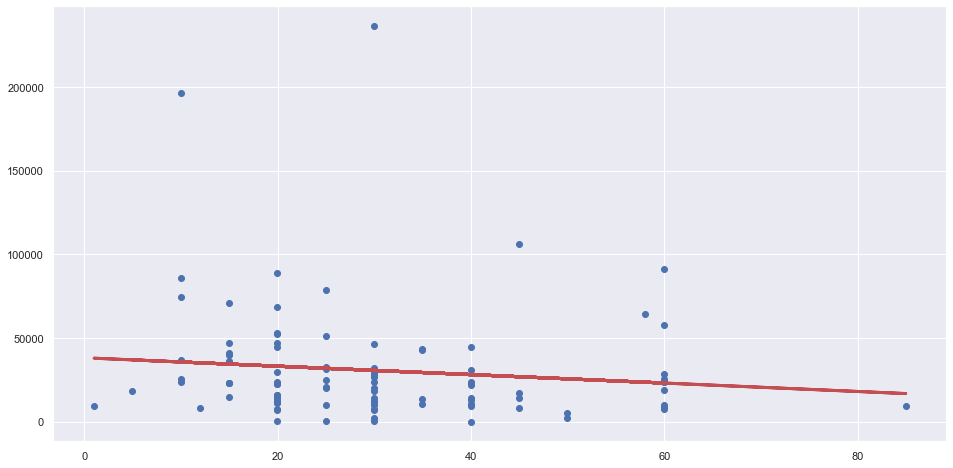

In [160]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()

linreg.fit(price_train, numreviews_train)

regline_x = price_train
regline_y = linreg.intercept_ + linreg.coef_ * price_train

f = plt.figure(figsize=(16, 8))
plt.scatter(price_train, numreviews_train)
plt.plot(regline_x, regline_y, 'r-', linewidth = 3)
plt.show()

In [56]:
steamData_playtime = steamData[['name', 'median_playtime']]

print("Number of times a user did not play a game they owned:", 
      len(steamData_playtime[steamData_playtime['median_playtime'] == 0]))

#shows that many players do not actually even start a game that they actually own

Number of times a user did not play a game they owned: 20905


In [71]:
steamData_playtime[steamData_playtime!= 0]
cols = ["median_playtime"]
steamData_playtime[cols] = steamData_playtime[cols].replace({'0':np.nan, 0:np.nan})
steamData_playtime.dropna(subset = ["median_playtime"], inplace=True)
steamData_playtime = steamData_playtime.rename(columns={"name": "title"})

steam_playtime = pd.DataFrame(steamData_playtime[['title','median_playtime']])

steam_playtime1 = steam_playtime[steam_playtime['median_playtime'].between(50, 2000)]
steam_playtime1

,title,median_playtime
0,Counter-Strike,317
1,Team Fortress Classic,62
3,Deathmatch Classic,184
4,Half-Life: Opposing Force,415
6,Half-Life,83
...,...,...
25950,古剑奇谭三(Gujian3),823
25973,Miracle snack shop 기적의 분식집,816
26313,Endzeit,88
26681,東方幕華祭 春雪篇 ～ Fantastic Danmaku Festival Part II,154


<AxesSubplot:ylabel='Count'>

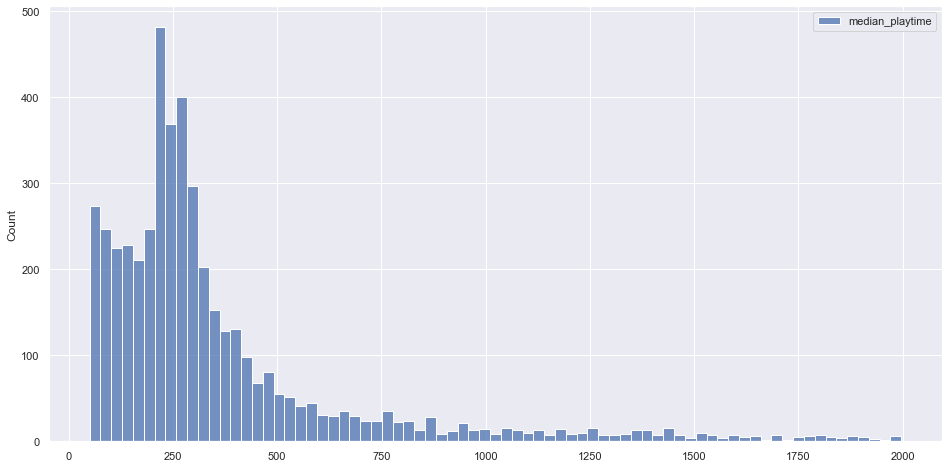

In [72]:
f = plt.figure(figsize=(16, 8))
sb.histplot(data = steam_playtime1)

It can be seen from the histogram that majority of players stops playing the game once it reaches 250 minutes or 4.2 hours of gameplay. Indicating that the gameplay length reduces interest in the game over time

In [ ]:
steam_playtime.to_excel("steam_playtime.xlsx")

In [11]:
#sorting games by average minutes of playtime per game when reviewing